# Notebook to Follow Experiment Tracking Lessons

In [1]:
!python -V

Python 3.9.16


In [5]:
from pathlib import Path
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [6]:
data_pth = Path('./data/')

In [7]:
df = pd.read_parquet(data_pth/'green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829626

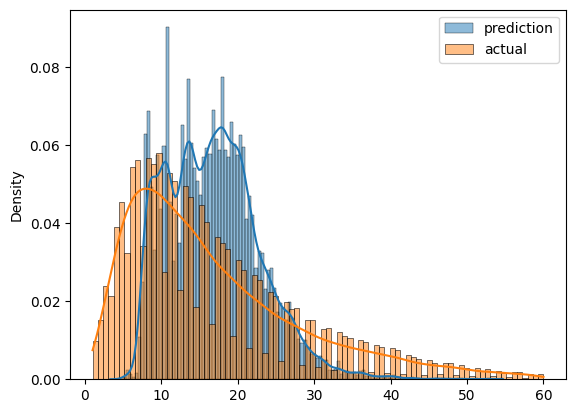

In [18]:
sns.histplot(y_pred, label='prediction', kde=True, stat='density', bins='auto')
sns.histplot(y_train, label='actual', kde=True, stat='density', bins='auto')

plt.legend()
plt.show()

In [19]:
# function to read dataframe
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [20]:
# read files as train and validation
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [21]:
len(df_train), len(df_val)

(73908, 61921)

In [22]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [23]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [24]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715206931833

In [26]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [27]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728

# Experiment Tracking with MLflow

In [28]:
import mlflow 
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-experiment')

<Experiment: artifact_location='/Users/addingtongraham/github-repos/mlops/experiment-tracking/mlruns/1', creation_time=1683821980697, experiment_id='1', last_update_time=1683821980697, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [30]:
with mlflow.start_run():
    mlflow.set_tag('developer', 'kai')
    mlflow.log_param('train-data-path', data_pth/'green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data-path', data_pth/'green_tripdata_2021-02.parquet')
    
    alpha = 0.1
    mlflow.log_param('alpha',alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)
    mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path='models_pickle')

## Hyperparameter Tuning with MLflow